## Hockey 2D: Aprendizaje por Refuerzo Multi-Agente con Q-learning Independiente

En este proyecto se desarrolla un entorno de Hockey 2D donde dos agentes autónomos aprenden a jugar utilizando Aprendizaje por Refuerzo, usando py game para visualizar, numpy para manejar vectores , matrices y calculos numericos, matplotlib para graficar,  y time Para controlar pausas, tiempos de espera y medir duración de episodios

In [1]:
import numpy as np, random, pygame, time
import matplotlib.pyplot as plt 

c:\Users\LENOVO\anaconda3\envs\NewEntorno3\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Configuración del mundo de Hockey 2D
definimos el tamaño de la cancha, las acciones posibles, cómo representamos el estado del juego (jugadores + puck), la posición inicial de cada elemento y los parámetros para dibujar el entorno con pygame

In [2]:
# ==============================
# 1) CONFIGURACIÓN DEL MUNDO
# ==============================
N_ROWS, N_COLS = 6, 7

# Acciones
A_UP, A_DOWN, A_LEFT, A_RIGHT = range(4) # 0,1,2,3
ACTIONS = [A_UP, A_DOWN, A_LEFT, A_RIGHT] # Lista de acciones (arriba, abajo, izquierda, derecha)

# Estados:
#   s = (ar1, ac1,   ar2, ac2,   pr, pc,   pd)
#         ↓abajo      ↑arriba     puck      dir(+1 baja / -1 sube)
# Posiciones iniciales
START_AGENT1 = (N_ROWS-1, 3)  # jugador 1 (abajo, azul)
START_AGENT2 = (0,         3) # jugador 2 (arriba, naranja)
START_PUCK   = (1,         3) # puck
START_DIR    = +1                      # empieza bajando
# Límites superior e inferior (para rebotar o detectar gol)
TOP_ROW, BOTTOM_ROW = 0, N_ROWS-1

# Arcos (portería como un hueco horizontal):
GOAL_WIDTH_CELLS = 3             # <--- cambia el ancho del arco
GOAL_CENTER_COL  = N_COLS // 2   # 3 <--- mueve el arco izq/der Columna central
GOAL_LEFT  = max(0, GOAL_CENTER_COL - GOAL_WIDTH_CELLS // 2) # Borde
GOAL_RIGHT = min(N_COLS-1, GOAL_LEFT + GOAL_WIDTH_CELLS - 1) # Borde
GOAL_THICK_PX = 6 # Grosor del dibujo del arco en píxeles

# Render pygame

CELL, MARGIN = 64, 40    # Tamaño de cada celda y margen alrededor
W, H = N_COLS*CELL + 2*MARGIN, N_ROWS*CELL + 2*MARGIN # Ancho y alto de la ventana

RENDER_EVERY       = 25
RENDER_DELAY_TRAIN = 25  # Pausa (ms) entre frames durante el entrenamiento
RENDER_DELAY_DEMO  = 150
# Modo lento (1.0 = normal)
# SLOW_MULT = 2.5


## Entorno del Juego
Esta clase define todo el funcionamiento del juego de Hockey 2D:
cómo se inicializan los jugadores y el puck
cómo se mueven
cómo rebota el puck
cómo se detectan los goles
cómo se calculan las recompensas
qué representa un estado del entorno
Este entorno es compatible con aprendizaje por refuerzo con dos agentes.

In [3]:
class HockeyEnv:
    STEP_PENALTY = -0.1

    def __init__(self):
        self.reset() # Al crear el entorno, lo inicializamos
    # -------------------------------------------
    # Reinicia el entorno a las posiciones iniciales
    # -------------------------------------------
    def reset(self):
        self.ar1, self.ac1 = START_AGENT1
        self.ar2, self.ac2 = START_AGENT2
        self.pr,  self.pc  = START_PUCK
        self.pd= START_DIR # dirección vertical del puck
        return self.get_state() # Devuelve el estado actual

    # -------------------------------------------
    # Mover un jugador según la acción elegida
    # -------------------------------------------
    def move(self, rc, action):
        r, c = rc
        if action == A_UP:    r -= 1
        if action == A_DOWN:  r += 1
        if action == A_LEFT:  c -= 1
        if action == A_RIGHT: c += 1
        r = max(0, min(N_ROWS-1, r))
        c = max(0, min(N_COLS-1, c))
        return (r, c)

    # Movimiento lateral aleatorio del puck
    # Simula desvíos naturales izquierda/derecha
    def lateral_drift(self, pc):
        r = random.random()
        step = -1 if r < 0.15 else (1 if r < 0.30 else 0)

        if pc == 0 and step == -1:
            step = +1
        elif pc == N_COLS - 1 and step == +1:
            step = -1
        return pc + step

    # Codificación reducida del estado para Jugador 1
    # Usa diferencias (puck - jugador) para simplificar
    def encode_for_j1(self, s):
        ar1, ac1, ar2, ac2, pr, pc, pd = s
        dr = np.clip(pr - ar1, -2, 2) # diferencia vertical limitada
        dc = np.clip(pc - ac1, -2, 2) # diferencia horizontal limitada
        return (int(dr), int(dc), int(pd))

    def encode_for_j2(self, s):
        ar1, ac1, ar2, ac2, pr, pc, pd = s
        dr = np.clip(pr - ar2, -2, 2)
        dc = np.clip(pc - ac2, -2, 2)
        return (int(dr), int(dc), int(pd))

     # Obtiene el estado completo del entorno
    def get_state(self):
        return (self.ar1, self.ac1, self.ar2, self.ac2, self.pr, self.pc, self.pd)

    # -------------------------------------------
    def step(self, a1, a2):
        # Mover jugadores
        self.ar1, self.ac1 = self.move((self.ar1, self.ac1), a1)
        self.ar2, self.ac2 = self.move((self.ar2, self.ac2), a2)

        # Move puck
        self.pc = self.lateral_drift(self.pc)
        self.pr = max(0, min(N_ROWS-1, self.pr + self.pd))

        hit1 = (self.ar1, self.ac1) == (self.pr, self.pc)
        hit2 = (self.ar2, self.ac2) == (self.pr, self.pc)
        if hit1 or hit2:
            self.pd = -self.pd
            self.pr = max(0, min(N_ROWS-1, self.pr + self.pd))

        r1 = r2 = self.STEP_PENALTY
        done = False

        in_top_goal = (self.pr == TOP_ROW) and (GOAL_LEFT <= self.pc <= GOAL_RIGHT) and (self.pd == -1)
        in_bottom_goal = (self.pr == BOTTOM_ROW) and (GOAL_LEFT <= self.pc <= GOAL_RIGHT) and (self.pd == +1)

        if in_top_goal:
            r1, r2, done = +1.0, -1.0, True
        elif in_bottom_goal:
            r1, r2, done = -1.0, +1.0, True

        return self.get_state(), r1, r2, done



## Aprendizaje Q-Learning Independiente
Cada jugador (agente) aprende su propia función Q(s, a) de forma independiente.
Esta clase implementa:
Tabla Q usando un diccionario,
Política ε-greedy (exploración vs explotación),
Actualización de Q-Learning,
Decaimiento progresivo de ε (menos exploración con el tiempo)

In [4]:
# ============================================================
# 2) CLASE AGENTE (Q-Learning Independiente)
# ============================================================
class Agent:
    def __init__(self, name, alpha=0.2, gamma=0.95, eps0=0.9, eps_min=0.05, eps_decay=0.995):
        self.name = name
        self.Q = {}  # Tabla Q almacenada como diccionario
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps0 # ε inicial (mucha exploración al principio)
        self.eps_min = eps_min # ε mínimo (nunca dejar de explorar completamente)
        self.eps_decay = eps_decay

    def q_value(self, s, a):
        return self.Q.get((s, a), 0.0)

    def best_action(self, s):
        qs = np.array([self.q_value(s, a) for a in ACTIONS], dtype=float) # calcular Q(s,a) para todas las acciones
        m = np.max(qs)  # m es el valor Q máximo entre las 4 acciones.  Ejemplo si qs = [0.1, -0.2, 0.1, 0.0]
        best_as = np.where(qs == m)[0]
        a = int(np.random.choice(best_as))
        return a, float(m)
    # Política ε-greedy:
    def choose_action(self, s):
        if random.random() < self.eps:
            return random.choice(ACTIONS)
        return self.best_action(s)[0]
    # Regla de actualización de Q-Learning:
    # Q(s,a) ← Q(s,a) + α [r + γ max_a' Q(s',a') - Q(s,a)]
    def update(self, s, a, r, s_next):
        _, max_next = self.best_action(s_next)
        old = self.q_value(s, a)
        td_target = r + self.gamma * max_next
        new = old + self.alpha * (td_target - old)
        self.Q[(s, a)] = new

    def decay_epsilon(self):
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

## Visualización del Juego con Pygame
Esta clase se encarga de dibujar el mundo de Hockey 2D en pantalla:

crea la ventana de pygame

dibuja la cuadrícula (cancha) y las porterías

dibuja los jugadores y el puck

muestra texto informativo (por ejemplo: episodio, recompensas, ε, etc.)

In [5]:
# ============================================================
# 4) CLASE RENDER (DIBUJO CON PYGAME)
# ============================================================
class Renderer:
    # Inicializar pygame y crear ventana
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((W, H))
        pygame.display.set_caption("Hockey 2D – POO")

    def to_xy(self, r, c):
        x = MARGIN + c * CELL + CELL // 2
        y = MARGIN + r * CELL + CELL // 2
        return x, y
    # Dibuja la cancha: fondo, líneas de grilla y arcos
    def draw_grid(self):
        screen = self.screen
        screen.fill((25, 28, 35))
        for r in range(N_ROWS+1):
            pygame.draw.line(screen,(70,70,80),
                             (MARGIN, MARGIN+r*CELL),
                             (MARGIN+N_COLS*CELL, MARGIN+r*CELL), 1)
        for c in range(N_COLS+1):
            pygame.draw.line(screen,(70,70,80),
                             (MARGIN+c*CELL, MARGIN),
                             (MARGIN+c*CELL, MARGIN+N_ROWS*CELL), 1)

        top_goal_x = MARGIN + GOAL_LEFT * CELL
        w_px = (GOAL_RIGHT - GOAL_LEFT + 1) * CELL
        pygame.draw.rect(screen,(50,160,80),
                         (top_goal_x, MARGIN - (GOAL_THICK_PX+2), w_px, GOAL_THICK_PX))
        pygame.draw.rect(screen,(200,70,70),
                         (top_goal_x, MARGIN + N_ROWS*CELL + 2, w_px, GOAL_THICK_PX))


    def draw(self, env, info=""):
        screen = self.screen
        self.draw_grid()

        # jugadores
        pygame.draw.circle(screen,(70,170,255), self.to_xy(env.ar1, env.ac1), CELL//3)
        pygame.draw.circle(screen,(255,170,70), self.to_xy(env.ar2, env.ac2), CELL//3)
        pygame.draw.circle(screen,(240,240,240), self.to_xy(env.pr, env.pc), CELL//6)

        font = pygame.font.SysFont("arial", 18)
        if info:
            screen.blit(font.render(info, True, (220,220,230)), 
                        (MARGIN, H - int(MARGIN*0.6)))

        pygame.display.flip()


##  Entrenamiento de los Agentes con Q-Learning
En esta función implementamos el ciclo completo de entrenamiento de dos agentes independientes.
Cada episodio simula una partida de Hockey 2D:

Reset del entorno

Ambos jugadores eligen acciones (política ε-greedy)

Se actualizan las tablas Q

Ocasionalmente se renderiza el episodio

Se registra la recompensa acumulada de cada jugador

Se reduce ε para disminuir exploración con el tiempo

In [6]:
# 5) ENTRENAMIENTO
# ============================================================
def run_training(episodes=2000, max_steps=180):
    env = HockeyEnv()
    render = Renderer()
    j1 = Agent("J1")
    j2 = Agent("J2")

    rewards1, rewards2 = [], []
    # Bucle de episodios
    for ep in range(1, episodes+1):
        s = env.reset()
        R1 = R2 = 0.0
        render_now = (ep % RENDER_EVERY == 0)

        for t in range(max_steps):

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    raise SystemExit
            # Codificar estado desde la perspectiva de cada jugador
            s1 = env.encode_for_j1(s)
            s2 = env.encode_for_j2(s)
            # Selección de acciones con política ε-greedy
            a1 = j1.choose_action(s1)
            a2 = j2.choose_action(s2)
              # Ejecutar acciones en el entorno
            s_next, r1, r2, done = env.step(a1, a2)
            R1 += r1; R2 += r2
            # Actualizar tabla Q de ambos agentes
            j1.update(s1, a1, r1, env.encode_for_j1(s_next))
            j2.update(s2, a2, r2, env.encode_for_j2(s_next))

            if render_now:
                render.draw(env, f"TRAIN EP={ep} step={t}")

            s = s_next
            if done: break

        j1.decay_epsilon()
        j2.decay_epsilon()

        rewards1.append(R1)
        rewards2.append(R2)

    print("\nEntrenamiento terminado ✔")

    plt.plot(rewards1, label="Jugador 1")
    plt.plot(rewards2, label="Jugador 2")
    plt.legend()
    plt.grid(True)
    plt.title("Recompensas por episodio")
    plt.show()

    return env, render, j1, j2



## Visualización del Juego con Agentes Entrenados

En esta función usamos los agentes ya entrenados para jugar partidas de demostración.

In [7]:
# ============================================================
# 6) DEMO FINAL
# ============================================================
def run_demo(env, render, j1, j2, episodes=5, max_steps=180):

    for demo in range(episodes):
        s = env.reset()

        for t in range(max_steps):
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit(); raise SystemExit

            s1 = env.encode_for_j1(s)
            s2 = env.encode_for_j2(s)

            a1, v1 = j1.best_action(s1)
            a2, v2 = j2.best_action(s2)

            s_next, r1, r2, done = env.step(a1, a2)
            render.draw(env, f"DEMO EP={demo+1} | V1={v1:.2f} V2={v2:.2f}")

            pygame.time.delay(RENDER_DELAY_DEMO)
            s = s_next
            if done:
                pygame.time.delay(500)
                break



Entrenamiento terminado ✔


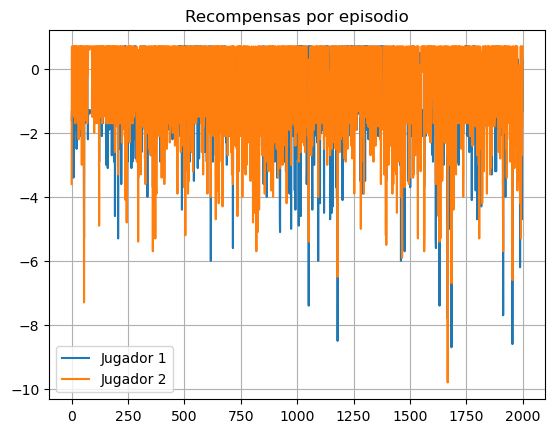

: 

In [ ]:
# ============================================================
# 7) EJECUCIÓN
# ============================================================
env, render, j1, j2 = run_training()
run_demo(env, render, j1, j2)

muestra cómo evoluciona el desempeño de ambos jugadores.
La gráfica muestra las recompensas acumuladas por cada jugador en cada episodio.
Las recompensas negativas predominan porque cada paso tiene un costo (-0.1) y los goles son escasos.